# Testing Output Files - Used for DEBUG Outputs
### TDT pipeline
Peter Yazdi

In [1]:
#imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
import os
from json_minify import json_minify
import json
import numpy as np
from scipy.ndimage import zoom

# SETUP - USER ADJUST FOR TEST FILE

In [2]:
current_file = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/' # Path of current file
config_path = os.path.join(current_file, 'inputs/config.json') # Path of configuration file

with open(config_path, encoding="utf-8") as f:
    config = json.loads(json_minify(f.read())) # Load configuration file
    
output_folder_path = os.path.join(current_file,config["output_folder"]["title"]) # Path of output folder
print("Output folder path:", output_folder_path)


roi_list = list(config['spect_preprocessing']['roi_subset'])
if 'body' not in roi_list:
    roi_list.append('body')
print("ROI list:", roi_list)

def adjust_roi(roi_subset):
        has_left = "kidney_left" in roi_subset
        has_right = "kidney_right" in roi_subset

        if has_left and not has_right:
            raise ValueError("PBPK requires both kidneys (missing kidney_right).")
        if has_right and not has_left:
            raise ValueError("PBPK requires both kidneys (missing kidney_left).")

        if has_left and has_right:
            new_subset = [r for r in roi_subset if r not in ("kidney_left", "kidney_right")]
            if "kidney" not in new_subset:
                new_subset.append("kidney")
            return new_subset

        return list(roi_subset)
    

roi_list = adjust_roi(roi_list)
print("Adjusted ROI list:", roi_list)

Output folder path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes
ROI list: ['kidney_right', 'kidney_left', 'liver', 'body']
Adjusted ROI list: ['liver', 'body', 'kidney']


# INPUT CT

Loading input CT from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/inputs/CT
Input CT path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/inputs/CT


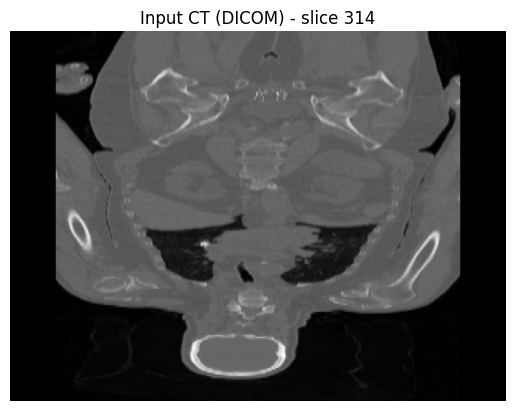

In [3]:
#input CT 
input_ct_path = config["ct_input"]["path1"]
print("Loading input CT from:", input_ct_path)

print("Input CT path:", input_ct_path)
if os.path.isdir(input_ct_path):
    reader = sitk.ImageSeriesReader()
    series_id = reader.GetGDCMSeriesIDs(input_ct_path)[0]
    file_names = reader.GetGDCMSeriesFileNames(input_ct_path, series_id)
    reader.SetFileNames(file_names)
    img = reader.Execute()
    arr_zyx = sitk.GetArrayFromImage(img)          # (z, y, x)
    vol = arr_zyx       # -> (x, y, z)
    title = "Input CT (DICOM)"
    


else:
    # NIfTI file (nibabel)
    vol = nib.load(input_ct_path).get_fdata()
    if vol.ndim == 4:
        vol = vol[..., 0]
    title = "Input CT (NIfTI)"

# Plot slice
axis=1
cmap="gray"
slice_idx = vol.shape[axis] // 2
sl = np.take(vol, slice_idx, axis=axis)

plt.imshow(sl, cmap=cmap, aspect = 'auto')
plt.title(f"{title} - slice {slice_idx}")
plt.axis("off")
plt.show()

# SPECT PREPROCESSING OUTPUTS

### Setup

In [4]:
# spect preprocessing outputs path
spect_preprocessing_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_preprocessing'])
print("Loading SPECT preprocessing outputs from:", spect_preprocessing_dir_path)
spect_preprocessing_prefix = config['spect_preprocessing']['name']

#files

# confirm run_totseg outputs (nii files)
ct_nii_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_ct.nii.gz')
roi_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_seg.nii.gz')
body_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_seg_dir/body.nii.gz')
print("CT NIfTI path:", ct_nii_path)
print("ROI Segmentation path:", roi_seg_path)
print("Body Segmentation path:", body_seg_path)

# check bin outputs
atn_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_atn_av.bin')
roi_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_seg.bin')
body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_seg.bin')
roi_body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_body_seg.bin')
print("ATN binary path:", atn_bin_path)
print("ROI Segmentation path:", roi_seg_bin_path)
print("Body Segmentation path:", body_seg_bin_path)
print("ROI and Body Segmentation path:", roi_body_seg_bin_path)



Loading SPECT preprocessing outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs
CT NIfTI path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs/spect_preprocessing_ct.nii.gz
ROI Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs/spect_preprocessing_roi_seg.nii.gz
Body Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs/spect_preprocessing_body_seg_dir/body.nii.gz
ATN binary path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs/spect_preprocessing_atn_av.bin
ROI Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/spect_preprocessing_outputs/spect_preprocessing_roi_seg.bin
Body Segmentation path: /home

### Nii.gz Files DATA + PLOTS

In [5]:
def print_nii_info(name, img):
    """
    Print NIfTI image information."""
    hdr = img.header
    print(f"\n--- {name} ---")
    print(f"shape: {img.shape}, dtype: {hdr.get_data_dtype()}")
    print("voxel spacing mm (zooms):", hdr.get_zooms())
    print("affine:\n", img.affine)
    
#load nii files
ct_nii = nib.load(ct_nii_path)
roi_seg = nib.load(roi_seg_path)
body_seg = nib.load(body_seg_path)

# --- Print NIfTI info ---
print_nii_info("CT", ct_nii)
print_nii_info("ROI Seg", roi_seg)
print_nii_info("Body Seg", body_seg)

# --- Arr spacing checks ---
ct_hdr = ct_nii.header
roi_hdr = roi_seg.header
body_hdr = body_seg.header

ct_zooms = ct_hdr.get_zooms()
roi_zooms = roi_hdr.get_zooms()
body_zooms = body_hdr.get_zooms()




--- CT ---
shape: (629, 629, 224), dtype: float64
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.97581184), np.float32(4.987864))
affine:
 [[-9.75807130e-01  2.99624959e-03  2.28539706e-04  3.05914795e+02]
 [ 2.99574574e-03  9.75770175e-01 -4.34496403e-02 -1.42318649e+02]
 [ 7.08361549e-05  8.50018952e-03  4.98767471e+00  8.69822021e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- ROI Seg ---
shape: (629, 629, 224), dtype: uint8
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.97581184), np.float32(4.987864))
affine:
 [[-9.75807130e-01  2.99624959e-03  2.28539706e-04  3.05914795e+02]
 [ 2.99574574e-03  9.75770175e-01 -4.34496403e-02 -1.42318649e+02]
 [ 7.08361549e-05  8.50018952e-03  4.98767471e+00  8.69822021e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- Body Seg ---
shape: (629, 629, 224), dtype: uint8
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.9758118), np.float32(4.987864

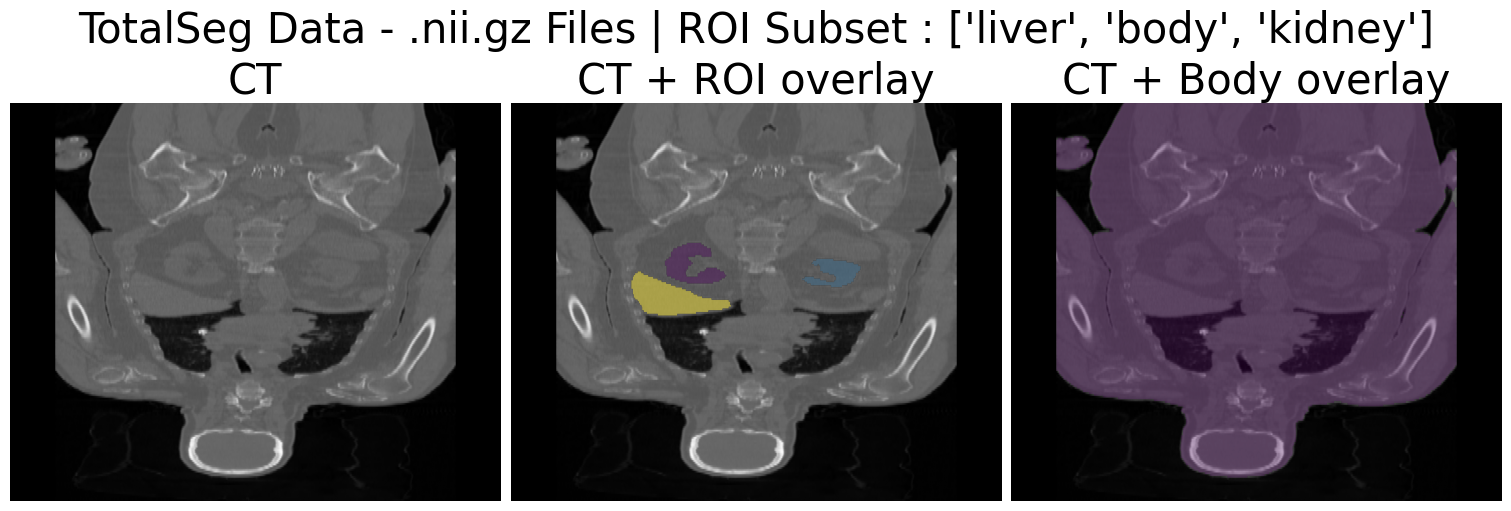

In [6]:
# ------- PLOT SLICES WITH OVERLAYS -------
# data arrays
ct_data   = np.array(ct_nii.get_fdata().transpose((2, 1, 0)), dtype=np.float32)
roi_data  = np.array(roi_seg.get_fdata().transpose((2, 1, 0)), dtype=np.float32)
body_data = np.array(body_seg.get_fdata().transpose((2, 1, 0)), dtype=np.float32)

# select middle slice index in y-direction
slice_index = ct_data.shape[1] // 2

ct_sl   = ct_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]
body_sl = body_data[:, slice_index, :]

ncols = 3
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)

# 1) CT only
ax[0].imshow(ct_sl, cmap="gray",aspect='auto')
ax[0].set_title("CT",fontsize=30)
ax[0].axis("off")

# 2) CT + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(ct_sl, cmap="gray",aspect='auto')
roi_masked = np.ma.masked_where(roi_sl == 0, roi_sl)
im1 = ax[1].imshow(roi_masked, alpha=0.45,aspect='auto')  
ax[1].set_title("CT + ROI overlay",fontsize=30)
ax[1].axis("off")

# 3) CT + Body overlay
ax[2].imshow(ct_sl, cmap="gray",aspect='auto')
body_masked = np.ma.masked_where(body_sl == 0, body_sl)
im2 = ax[2].imshow(body_masked, alpha=0.35,aspect='auto')
ax[2].set_title("CT + Body overlay",fontsize=30)
ax[2].axis("off")

fig.suptitle(f"TotalSeg Data - .nii.gz Files | ROI Subset : {roi_list}", fontsize=30)
plt.show()

### .bin files plots

In [7]:
# realign and resize for plots

# should be same for all
shape = roi_data.shape
print("Original ROI shape:", roi_data.shape)
print("Array Type:", roi_data.dtype) 

resize = config['spect_preprocessing']['resize']
scale = resize / roi_data.shape[1]
roi_data_new = zoom(roi_data, (scale, scale, scale), order=0)
shape_new = roi_data_new.shape
print("Resized ROI shape:", shape_new)

Original ROI shape: (224, 629, 629)
Array Type: float32
Resized ROI shape: (91, 256, 256)


ROI unique values: [  0.   5. 100.]
Body unique values: [0. 1.]
ROI+Body unique values: [  0.   5. 100. 200.]


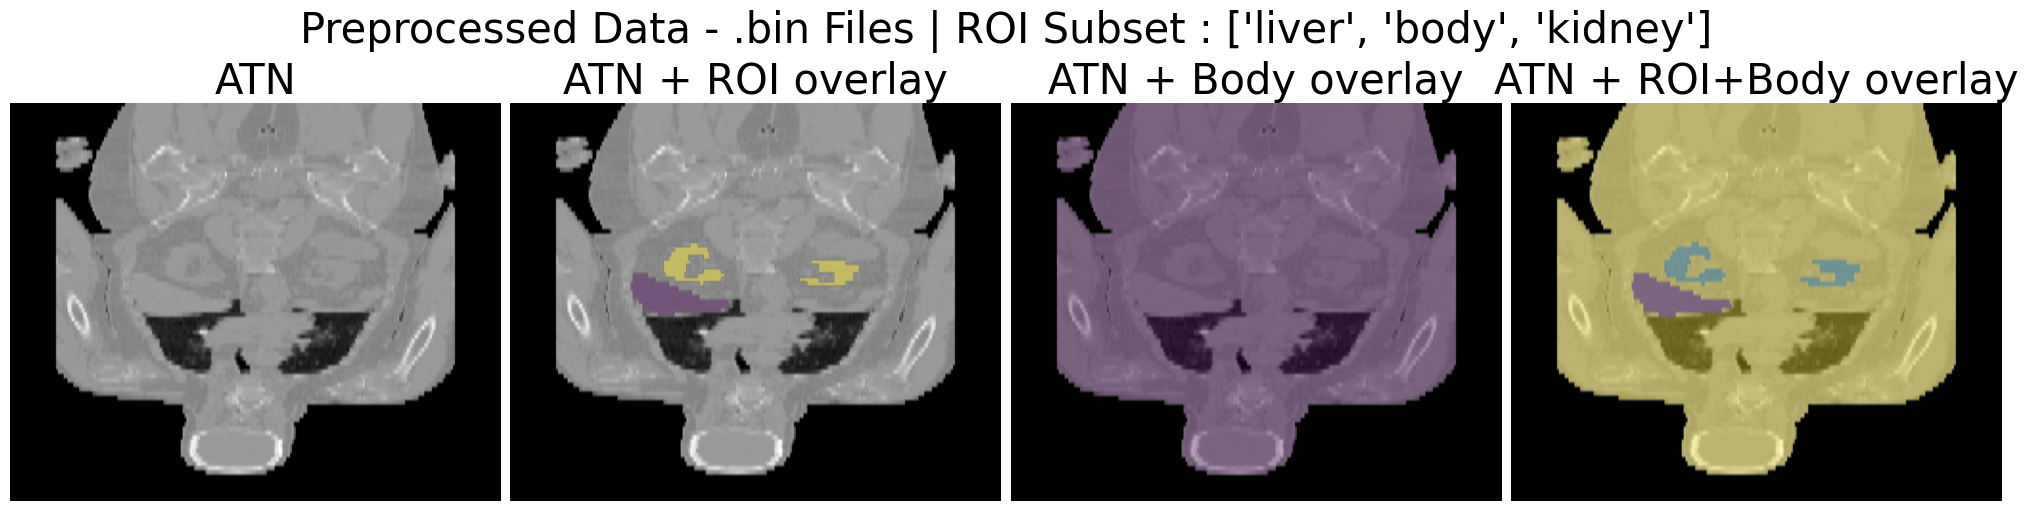

In [8]:
# ------- BIN FILES PLOTS -------
# data arrays
atn_data = np.fromfile(atn_bin_path, dtype=np.float32).reshape(shape_new)
roi_data = np.fromfile(roi_seg_bin_path, dtype=np.float32).reshape(shape_new)
body_data = np.fromfile(body_seg_bin_path, dtype=np.float32).reshape(shape_new)
roi_body_data = np.fromfile(roi_body_seg_bin_path, dtype=np.float32).reshape(shape_new)

print(f"ROI unique values: {np.unique(roi_data)}")
print(f"Body unique values: {np.unique(body_data)}")
print(f"ROI+Body unique values: {np.unique(roi_body_data)}")

slice_index = atn_data.shape[1] // 2

atn_sl   = atn_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]
body_sl = body_data[:, slice_index, :]
roi_body_sl = roi_body_data[:, slice_index, :]

ncols = 4
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)


# 1) ATN only
ax[0].imshow(atn_sl, cmap="gray", aspect='auto')
ax[0].set_title("ATN",fontsize=30)
ax[0].axis("off")

# 2) ATN + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(atn_sl, cmap="gray", aspect='auto')
roi_masked = np.ma.masked_where(roi_sl == 0, roi_sl)
im1 = ax[1].imshow(roi_masked, alpha=0.45, aspect='auto')
ax[1].set_title("ATN + ROI overlay",fontsize=30)
ax[1].axis("off")

# 3) ATN + Body overlay
ax[2].imshow(atn_sl, cmap="gray", aspect='auto')
body_masked = np.ma.masked_where(body_sl == 0, body_sl)
im2 = ax[2].imshow(body_masked, alpha=0.35, aspect='auto')
ax[2].set_title("ATN + Body overlay",fontsize=30)
ax[2].axis("off")

# 4) ATN + ROI+Body overlay
ax[3].imshow(atn_sl, cmap="gray", aspect='auto')
roi_body_masked = np.ma.masked_where(roi_body_sl == 0, roi_body_sl)
im3 = ax[3].imshow(roi_body_masked, alpha=0.35, aspect='auto')
ax[3].set_title("ATN + ROI+Body overlay",fontsize=30)
ax[3].axis("off")   


fig.suptitle(f"Preprocessed Data - .bin Files | ROI Subset : {roi_list}", fontsize=30)
plt.show()


# PBPK OUTPUTS

### Setup

In [9]:
pbpk_dir_path = os.path.join(output_folder_path, config['subdir_names']['pbpk'])
print("Loading PBPK outputs from:", pbpk_dir_path)
pbpk_prefix = config['pbpk']['name']

# check PBPK outputs TAC from PyCNO
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]

# grab shape details: 
shape  = shape_new
print("Shape of arrays:", shape) # all should be the same shape

# grab vois for PyCNO
vois = [v.lower() for v in config["pbpk"]["VOIs"]]
print("PBPK VOIs:", vois)

# grab rois from totalseg
rois = roi_list.copy()
print("Totalseg ROIs:", rois)

Loading PBPK outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_Validate_Classes/pbpk_outputs
Shape of arrays: (91, 256, 256)
PBPK VOIs: ['tumor1', 'tumor2', 'kidney', 'heart', 'sg', 'bone', 'tumorrest', 'spleen', 'liver', 'prostate', 'gi', 'rest', 'skin', 'muscle', 'brain', 'redmarrow', 'lungs', 'adipose']
Totalseg ROIs: ['liver', 'body', 'kidney']


#### TAC Produced Via PyCNO (Activity per ROI per Frame)

ROI: liver
Frame Time : 4 hrs | Activity: 422.5263366699219 MBq
Frame Time : 24 hrs | Activity: 96.28842163085938 MBq
Frame Time : 48 hrs | Activity: 40.48572540283203 MBq
Frame Time : 96 hrs | Activity: 13.533672332763672 MBq
ROI: body
Frame Time : 4 hrs | Activity: 1440.763916015625 MBq
Frame Time : 24 hrs | Activity: 241.66845703125 MBq
Frame Time : 48 hrs | Activity: 101.14690399169922 MBq
Frame Time : 96 hrs | Activity: 49.49240493774414 MBq
ROI: kidney
Frame Time : 4 hrs | Activity: 169.93740844726562 MBq
Frame Time : 24 hrs | Activity: 72.74077606201172 MBq
Frame Time : 48 hrs | Activity: 25.51279067993164 MBq
Frame Time : 96 hrs | Activity: 7.873067378997803 MBq


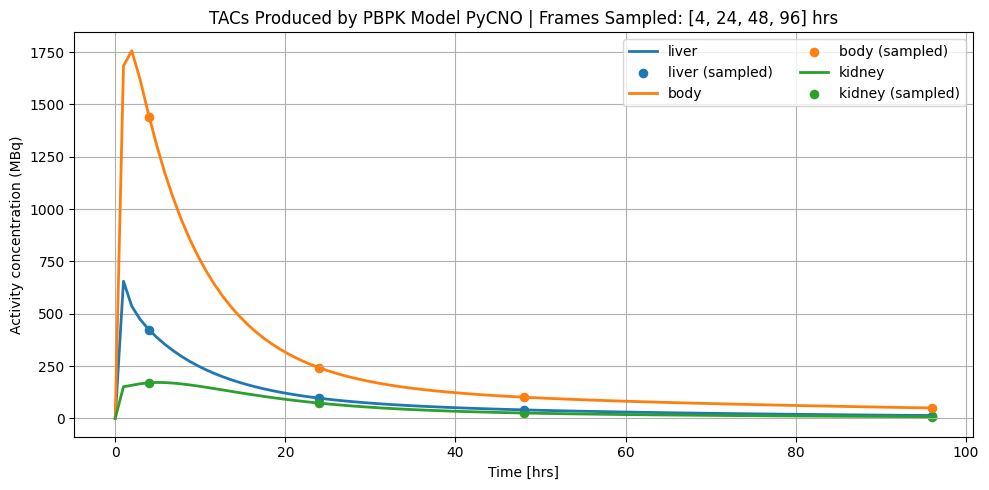

In [10]:
# ------- LOAD TAC BIN FILES-------
def load_tac_bins(roi, base_path=pbpk_dir_path, pbpk_prefix=pbpk_prefix):
    roi = roi.lower()
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_time.bin"), dtype=np.float32)
    act  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_values.bin"), dtype=np.float32)
    t_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_times.bin"), dtype=np.float32)
    act_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_values.bin"), dtype=np.float32)
    return t, act, t_s, act_s

# --- One plot for all ROIs ---
plt.figure(figsize=(10, 5))

sampled_activity = {}

for roi in rois:
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    if not os.path.exists(t_file):
        print(f"Skipping '{roi}' (missing files).")
        continue

    t, act, t_s, act_s = load_tac_bins(roi)

    plt.plot(t/60, act, linewidth=2, label=f"{roi}")
    plt.scatter(t_s/60, act_s, s=35, label=f"{roi} (sampled)")
    sampled_activity[roi] = act_s.astype(float).tolist()
for roi in sampled_activity:
    print(f"ROI: {roi}")
    for indx, fr in enumerate(frames_start_times):
        print(f"Frame Time : {int(fr/60)} hrs | Activity: {sampled_activity[roi][indx]} MBq")

plt.title(f"TACs Produced by PBPK Model PyCNO | Frames Sampled: {[int(f/60) for f in frames_start_times]} hrs")
plt.xlabel("Time [hrs]")
plt.ylabel("Activity concentration (MBq)")
plt.grid()
plt.legend(ncol=2)  # makes legend less tall if many ROIs
plt.tight_layout()
plt.show()

### Volumes of each ROI - Assume Activity Map uniform activty across organ

ROI List: ['liver', 'body', 'kidney']
Unique values in ROI+Body data: [  0   5 100 200]
Class map: {'liver': 5, 'kidney': 100, 'body': 200}


Calculating volumes for each ROI:
-----


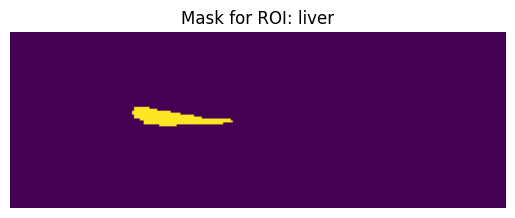

Volume of liver: 124.62 cm^3
-----
-----


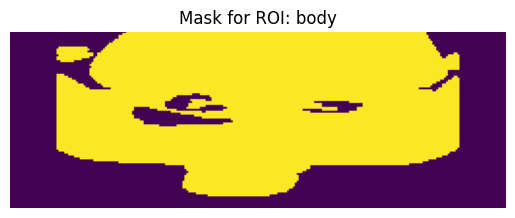

Volume of body: 5693.77 cm^3
-----
-----


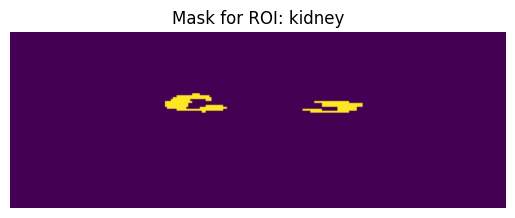

Volume of kidney: 39.63 cm^3
-----
Calculated Volumes (cm^3): {'liver': 124.6170504026413, 'body': 5693.770985959053, 'kidney': 39.62972286605835}


In [11]:
# find volumes of each ROI region :
roi_list = roi_list.copy()
print(f"ROI List: {roi_list}")

roi_body_data = np.fromfile(os.path.join(spect_preprocessing_dir_path, f"{spect_preprocessing_prefix}_roi_body_seg.bin"),
                            np.float32).reshape(shape).astype(int) # to avoid modifying original data
unique_values = np.unique(roi_body_data.astype(int))
print("Unique values in ROI+Body data:", unique_values)

def _build_class_map(arr, unique_values, classes):
        class_map = {}
        for value in unique_values:
            if value == 0:
                continue
            name = classes.get(str(value))
            if name is not None:
                class_map[name] = int(value)
        return class_map

classes = config['total_segmentator_classes']
class_map = _build_class_map(roi_body_data, unique_values, classes)
print("Class map:", class_map)
print("\n")

volume_roi = {}
mask_roi = {}
print("Calculating volumes for each ROI:")
for roi in roi_list:
    print("-----")
    mask = (roi_body_data == class_map.get(roi))
    plt.imshow(mask[:, mask.shape[1]//2, :])
    plt.title(f"Mask for ROI: {roi}")
    plt.axis("off")
    plt.show()
    
    volume_voxels = np.sum(mask) # count voxels in mask
    voxel_volume_mm3 = ct_zooms[0] * ct_zooms[1] * ct_zooms[2]  # assuming same spacing for all roi
    volume_mm3 = volume_voxels * voxel_volume_mm3
    volume_cm3 = volume_mm3 / 1000.0  # convert to cm^3
    print(f"Volume of {roi}: {volume_cm3:.2f} cm^3")
    print("-----")
    volume_roi[str(roi)] = float(volume_cm3)
    mask_roi[str(roi)] = mask.astype(np.uint8)
    

print("Calculated Volumes (cm^3):", volume_roi)


#### Frame-based PBPK Actitvty Map (.bin) Plots

Using shape for PBPK frames: (91, 256, 256)


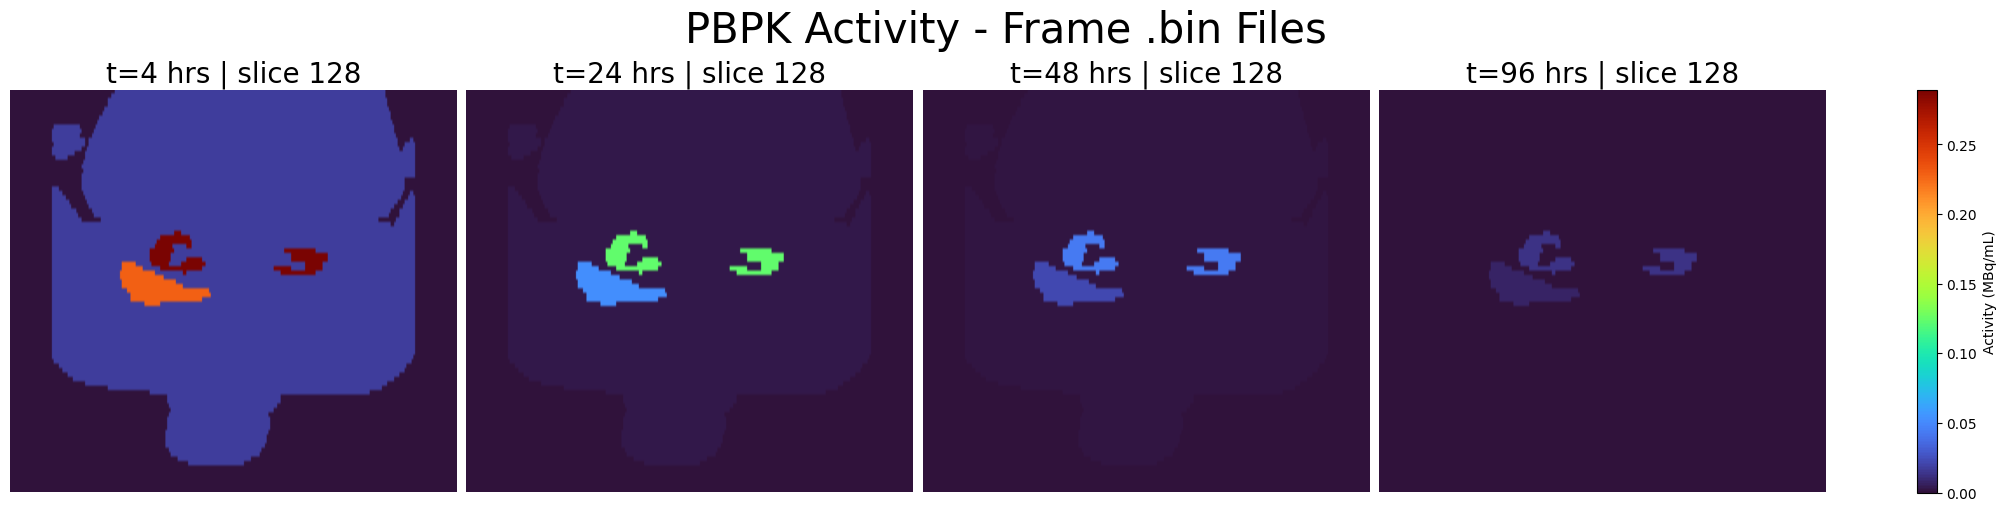

In [12]:
titles = []
slices = []
global_min = np.inf
global_max = -np.inf
shape  = shape_new
print("Using shape for PBPK frames:", shape)

for frame in frames_start_times:
    pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{frame}_act_av.bin"), dtype=np.float32).reshape(shape)
    
    slice_index = pbpk_frame_arr.shape[1] // 2  # same slice for all frames
    sl = pbpk_frame_arr[:, slice_index, :]
    
    # update global min/max (nan-safe)
    sl_min = np.nanmin(sl)
    sl_max = np.nanmax(sl)
    if sl_min < global_min: global_min = sl_min
    if sl_max > global_max: global_max = sl_max

    slices.append(sl)
    titles.append(f"t={int(frame/60)} hrs | slice {slice_index}")
    
# Common choice for activity maps:
vmin = 0.0 if np.isfinite(global_min) else 0.0
vmax = float(global_max) if np.isfinite(global_max) else 1.0

ncols = len(slices)
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

im = None
for i, ax in enumerate(axes):
    if i < len(slices):
        im = ax.imshow(slices[i], cmap="turbo", vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")

# one shared colorbar for the whole figure
fig.colorbar(im, ax=axes.tolist(), label="Activity (MBq/mL)")
fig.suptitle(f"PBPK Activity - Frame .bin Files", fontsize=30)
plt.show()

#### Ogran-based PBPK Actitvty Map (.bin) - Check bin made correctly

Using shape for PBPK frames: (91, 256, 256)


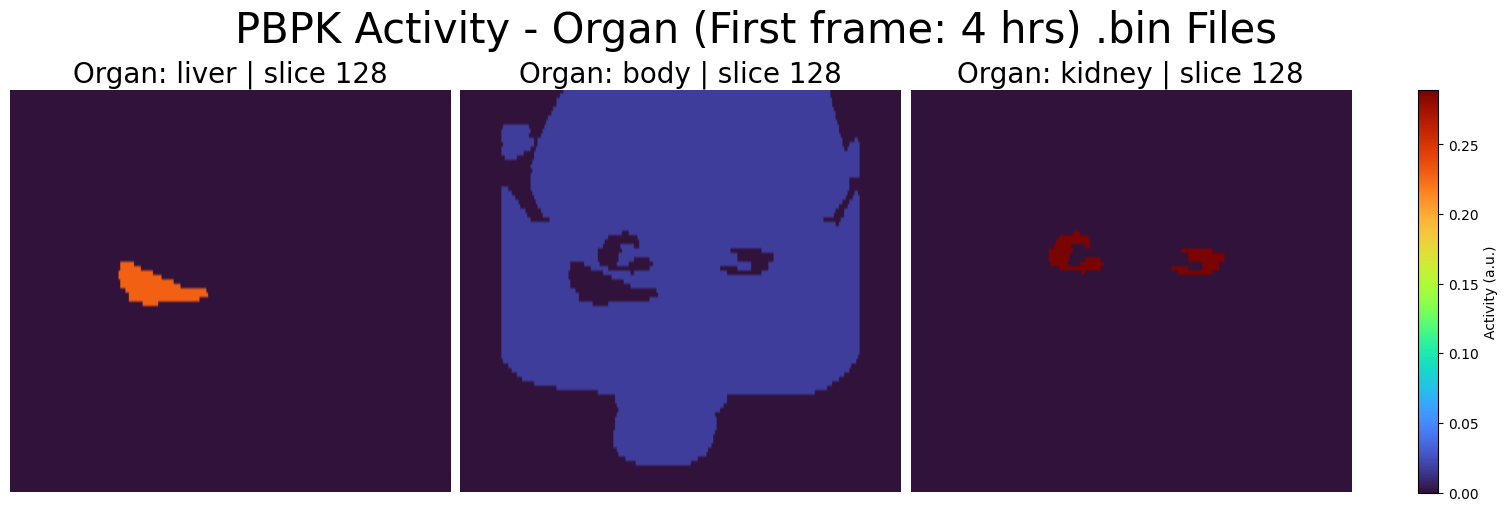

In [13]:
slices = []
titles = []
global_min = np.inf
global_max = -np.inf
shape = shape_new
print("Using shape for PBPK frames:", shape)
for organ in roi_list:
    pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{organ}_act_av.bin"), dtype=np.float32).reshape(shape)
    
    slice_index = pbpk_frame_arr.shape[1] // 2  # same slice for all frames
    sl = pbpk_frame_arr[:, slice_index, :]
    
    # update global min/max (nan-safe)
    sl_min = np.nanmin(sl)
    sl_max = np.nanmax(sl)
    if sl_min < global_min: global_min = sl_min
    if sl_max > global_max: global_max = sl_max

    slices.append(sl)
    titles.append(f"Organ: {organ} | slice {slice_index}")
    
# Common choice for activity maps:
vmin = 0.0 if np.isfinite(global_min) else 0.0
vmax = float(global_max) if np.isfinite(global_max) else 1.0

ncols = len(slices)
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

im = None
for i, ax in enumerate(axes):
    if i < len(slices):
        im = ax.imshow(slices[i], cmap="turbo", vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")

# one shared colorbar for the whole figure
fig.colorbar(im, ax=axes.tolist(), label="Activity (a.u.)")
fig.suptitle(f"PBPK Activity - Organ (First frame: {int(frames_start_times[0]/60)} hrs) .bin Files", fontsize=30)
plt.show()

### TAC via Pycno confirmed with Activity Map

#### Exepcted - Calulated via code

In [14]:
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]
TAC_sampled_values = sampled_activity # units of MBq, correpond to each frame
print("TAC Sampled Values:", TAC_sampled_values)
print("TAC Frame Start Times (hrs):", [int(f/60) for f in frames_start_times])

# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
volumes = volume_roi
roi_activity_Mbq_ml_expected = {}
for roi in roi_list:
    roi = roi.lower()
    print(f"--- ROI: {roi} ---")
    volume_cm3 = volumes.get(str(roi))  # in cm^3
    activity_values = TAC_sampled_values.get(roi)  # in MBq
    activity_Mbq_per_ml = []
    for activity in activity_values:
        activity_conc = activity / volume_cm3  # MBq/ml
        activity_Mbq_per_ml.append(activity_conc)
        print(f"Activity: {activity} MBq | Volume: {volume_cm3:.2f} cm^3 | Activity Concentration: {activity_conc:.2f} MBq/ml")
    roi_activity_Mbq_ml_expected[str(roi)] = activity_Mbq_per_ml
print("\n")
print(f"Expected ROI Activty [Mbq/ml]:\n{roi_activity_Mbq_ml_expected}")

TAC Sampled Values: {'liver': [422.5263366699219, 96.28842163085938, 40.48572540283203, 13.533672332763672], 'body': [1440.763916015625, 241.66845703125, 101.14690399169922, 49.49240493774414], 'kidney': [169.93740844726562, 72.74077606201172, 25.51279067993164, 7.873067378997803]}
TAC Frame Start Times (hrs): [4, 24, 48, 96]
--- ROI: liver ---
Activity: 422.5263366699219 MBq | Volume: 124.62 cm^3 | Activity Concentration: 3.39 MBq/ml
Activity: 96.28842163085938 MBq | Volume: 124.62 cm^3 | Activity Concentration: 0.77 MBq/ml
Activity: 40.48572540283203 MBq | Volume: 124.62 cm^3 | Activity Concentration: 0.32 MBq/ml
Activity: 13.533672332763672 MBq | Volume: 124.62 cm^3 | Activity Concentration: 0.11 MBq/ml
--- ROI: body ---
Activity: 1440.763916015625 MBq | Volume: 5693.77 cm^3 | Activity Concentration: 0.25 MBq/ml
Activity: 241.66845703125 MBq | Volume: 5693.77 cm^3 | Activity Concentration: 0.04 MBq/ml
Activity: 101.14690399169922 MBq | Volume: 5693.77 cm^3 | Activity Concentration: 

#### What .bin files have - From .bin saved in output folder

In [15]:
# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
shape  = shape_new
print("Using shape for PBPK frames:", shape)
roi_activity_Mbq_ml_calculated = {}

for roi in roi_list:
    print(f"--- ROI: {roi} ---")
    # create activity map based on roi masks and activity concentrations
    roi_activites = []
    roi = roi.lower()
    mask = masks.get(str(roi))
    for frame in frames_start_times:
        print(f"Processing frame at {int(frame/60)} hrs")
        pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{frame}_act_av.bin"), dtype=np.float32).reshape(shape)
        vals = pbpk_frame_arr[mask.astype(bool)]
        roi_mean = float(vals.mean())
        roi_activites.append(roi_mean)
    roi_activity_Mbq_ml_calculated[str(roi)] = roi_activites

print("\n")
print(f"Calculated ROI Activty [Mbq/ml]:\n{roi_activity_Mbq_ml_calculated}")


Using shape for PBPK frames: (91, 256, 256)
--- ROI: liver ---
Processing frame at 4 hrs
Processing frame at 24 hrs
Processing frame at 48 hrs
Processing frame at 96 hrs
--- ROI: body ---
Processing frame at 4 hrs
Processing frame at 24 hrs
Processing frame at 48 hrs
Processing frame at 96 hrs
--- ROI: kidney ---
Processing frame at 4 hrs
Processing frame at 24 hrs
Processing frame at 48 hrs
Processing frame at 96 hrs


Calculated ROI Activty [Mbq/ml]:
{'liver': [0.22858315706253052, 0.05209123715758324, 0.02190244011580944, 0.007321603130549192], 'body': [0.017059307545423508, 0.0028614632319658995, 0.00119762250687927, 0.0005860111559741199], 'kidney': [0.28909191489219666, 0.12374422699213028, 0.04340151697397232, 0.013393402099609375]}


In [16]:
calculated_activty = roi_activity_Mbq_ml_calculated
expected_activty = roi_activity_Mbq_ml_expected
print("Exepcting all difference be = 0")
for roi in roi_list:
    print(f"--- ROI: {roi} ---")
    calc_values = calculated_activty.get(str(roi))
    exp_values = expected_activty.get(str(roi))
    for indx, fr in enumerate(frames_start_times):
        calc_val = calc_values[indx]
        exp_val = exp_values[indx]
        diff = abs(calc_val - exp_val) 
        if diff != 0 :
            print("WARNING: Difference found!")
            print(f"X: Frame Time : {int(fr/60)} hrs | Calculated Activity: {calc_val:.4f} MBq/ml | Expected Activity: {exp_val:.4f} MBq/ml | Difference: {diff:.4f} MBq/ml")
        else :
            print(f"Frame Time : {int(fr/60)} hrs | Calculated Activity: {calc_val:.4f} MBq/ml | Expected Activity: {exp_val:.4f} MBq/ml | Difference: {diff:.4f} MBq/ml")
        


Exepcting all difference be = 0
--- ROI: liver ---
X: Frame Time : 4 hrs | Calculated Activity: 0.2286 MBq/ml | Expected Activity: 3.3906 MBq/ml | Difference: 3.1620 MBq/ml
X: Frame Time : 24 hrs | Calculated Activity: 0.0521 MBq/ml | Expected Activity: 0.7727 MBq/ml | Difference: 0.7206 MBq/ml
X: Frame Time : 48 hrs | Calculated Activity: 0.0219 MBq/ml | Expected Activity: 0.3249 MBq/ml | Difference: 0.3030 MBq/ml
X: Frame Time : 96 hrs | Calculated Activity: 0.0073 MBq/ml | Expected Activity: 0.1086 MBq/ml | Difference: 0.1013 MBq/ml
--- ROI: body ---
X: Frame Time : 4 hrs | Calculated Activity: 0.0171 MBq/ml | Expected Activity: 0.2530 MBq/ml | Difference: 0.2360 MBq/ml
X: Frame Time : 24 hrs | Calculated Activity: 0.0029 MBq/ml | Expected Activity: 0.0424 MBq/ml | Difference: 0.0396 MBq/ml
X: Frame Time : 48 hrs | Calculated Activity: 0.0012 MBq/ml | Expected Activity: 0.0178 MBq/ml | Difference: 0.0166 MBq/ml
X: Frame Time : 96 hrs | Calculated Activity: 0.0006 MBq/ml | Expected A

#### SPECT Simulation

#### PyTomography OUTPUTS